# Predicting Functionality of Waterpoints in Tanzania

place image here

## Business Problem

## Data

Data used in this classification project comes from an ongoing competition hosted by DrivenData, [*Pump it Up: Data Mining the Water Table*](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

In [2]:
# Packages for data cleaning, plotting, and manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# scikit-learn libraries/functions/classes
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

### Initial Data Cleaning and Comprehension

In [3]:
# Importing training data
# Only using `status_group` column from label set, to
# avoid duplicating `id` column
df_train_val = pd.read_csv('data/training_set_values.csv')
df_train_label = pd.read_csv('data/training_set_labels.csv',
                             usecols = ['status_group'])


df_test = pd.read_csv('data/test_set_values.csv')

In [15]:
# Concatenating separate .csv files
df_train = pd.concat(objs = [df_train_val, df_train_label],
                     axis = 1)

df_train.head();

In [5]:
# Checking for null values in features columns

df_train.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

Columns/features with large numbers of null values, from least to greatest quantity:

- `subvillage` (371)
- `permit` (3056)
- `public_meeting` (3334)
- `funder` (3635)
- `installer` (3655)
- `scheme_management` (3877)
- `scheme_name` (28166) **(!)**

<AxesSubplot:xlabel='waterpoint_type', ylabel='status_group'>

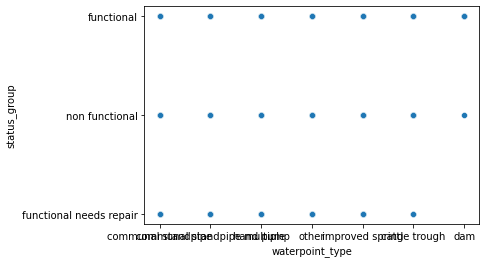

In [40]:
sns.scatterplot(x = df_train['waterpoint_type'],
                y = df_train['status_group'])

In [38]:
df_train['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [39]:
df_train['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [36]:
df_train['water_quality'].value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [37]:
df_train['quality_group'].value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

In [13]:
df_train['permit'].value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [18]:
df_train['scheme_name'].value_counts()

K                             682
None                          644
Borehole                      546
Chalinze wate                 405
M                             400
                             ... 
Uswa                            1
Mtunguruzi                      1
Mkuini paralle line             1
Misambo mlimani                 1
TM part Three water supply      1
Name: scheme_name, Length: 2696, dtype: int64

In [19]:
# Checking datatypes of columns

df_train.dtypes;

In [ ]:
# Dropping columns determined to be either irrelevant or
# superfluous in exploratory analysis

cols_to_drop = [
    'quantity_group',  # identical information to `quantity`
    'payment',  # identical information to `payment_type`
    'extraction_type',
    'extraction_type_group',  # using `extraction_type_class` for generalized info
]

## Preparation for Modeling

### Train/Test Split and Preparation for ML

In [7]:
# Splitting DataFrame into features/values DataFrame
# (i.e. `X`) and labels series (`y`)

X = df_train.drop('status_group', axis = 1)
y = df_train['status_group']

In [9]:
# Splitting internal training data into separate
# training and test sets for (eventual) internal validation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 666)

# Scrap Code

In [ ]:
# X.loc[X['funder'].isna()].head();